# Deep Learning for Brain Tumor Detection

**Experiment 1 =** initialization with ramdom weights and traning all layers.

**Experiment 2 =** initialization with resnet18 and traning all layers.

**Experiment 3 =** initialization with resnet18 and traning only the final (fully connected) layer.

In [1]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load Data

This code loads 2D images of health brains and bains containing tumors using a dataloader.

In [2]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = '../Data/Brain_Tumor_Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=6) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Visualize a few images (one batch)

Batch of training data


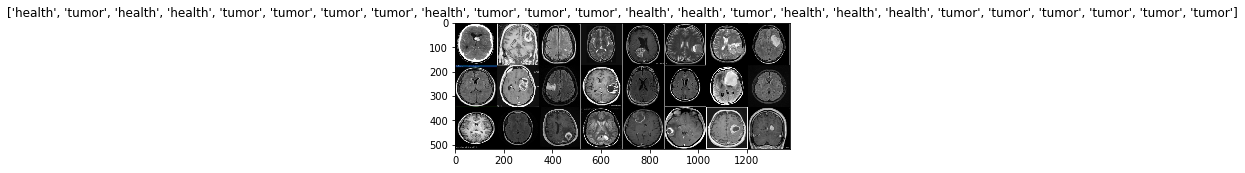

Batch of validation data


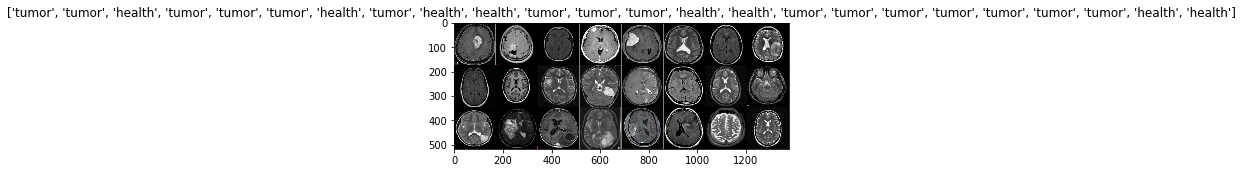

In [3]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### Experiment 1

**No transfer learning:** Rrandom initializaion and all weights will be retrained.

In [5]:
model_ft_randstart = models.resnet18(pretrained=False)
num_ftrs = model_ft_randstart.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_randstart.fc = nn.Linear(num_ftrs, 2)

model_ft_randstart = model_ft_randstart.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft_randstart.parameters(), lr=0.001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.0001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.00005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)

In [6]:
model_ft_randstart

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
summary(model_ft_randstart, (3, 170, 170))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

In [7]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7100 Acc: 0.5550
val Loss: 0.6523 Acc: 0.6613

Epoch 1/9
----------
train Loss: 0.6894 Acc: 0.6126
val Loss: 0.6900 Acc: 0.6129

Epoch 2/9
----------
train Loss: 0.6052 Acc: 0.6859
val Loss: 0.6461 Acc: 0.6774

Epoch 3/9
----------
train Loss: 0.5757 Acc: 0.7120
val Loss: 0.6242 Acc: 0.6613

Epoch 4/9
----------
train Loss: 0.5534 Acc: 0.7382
val Loss: 0.6091 Acc: 0.7419

Epoch 5/9
----------
train Loss: 0.5354 Acc: 0.7696
val Loss: 0.5636 Acc: 0.7581

Epoch 6/9
----------
train Loss: 0.5038 Acc: 0.7749
val Loss: 0.5276 Acc: 0.8548

Epoch 7/9
----------
train Loss: 0.4747 Acc: 0.8220
val Loss: 0.5033 Acc: 0.8548

Epoch 8/9
----------
train Loss: 0.4464 Acc: 0.8220
val Loss: 0.4788 Acc: 0.8226

Epoch 9/9
----------
train Loss: 0.4301 Acc: 0.8115
val Loss: 0.4723 Acc: 0.8710

Training complete in 1m 12s
Best val Acc: 0.870968


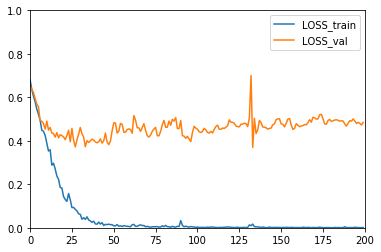

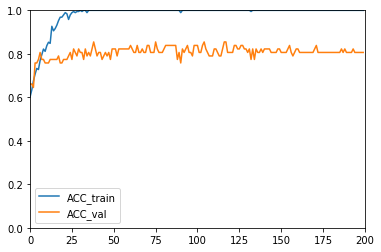

max ACC =  0.8548387096774194


In [28]:
file_path = '../Results/losses_acc_rand_lr0.0008_step200.npy'
# LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
# np.save(file_path, LOSSES)
LOSSES = np.load(file_path, allow_pickle=True)
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max().cpu().numpy())

**Learning Rate**

![learning rate](../Images/learning_rate.gif)

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=200)

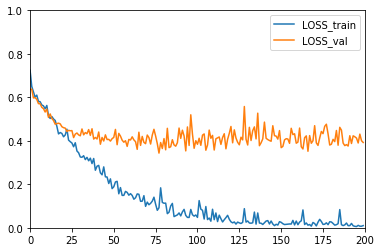

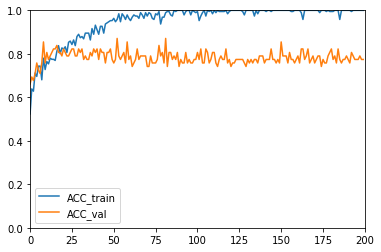

max ACC =  0.8709677419354839


In [25]:
file_path = '../Results/losses_acc_rand_lr0.0001_step200.npy'
# LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
# np.save(file_path, LOSSES)
LOSSES = np.load(file_path, allow_pickle=True)
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max().cpu().numpy())

In [9]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 0.7250 Acc: 0.4293
val Loss: 0.6878 Acc: 0.6129

Epoch 1/199
----------
train Loss: 0.6861 Acc: 0.5445
val Loss: 0.6650 Acc: 0.6613

Epoch 2/199
----------
train Loss: 0.6594 Acc: 0.6021
val Loss: 0.6476 Acc: 0.6613

Epoch 3/199
----------
train Loss: 0.6542 Acc: 0.5969
val Loss: 0.6422 Acc: 0.6613

Epoch 4/199
----------
train Loss: 0.6507 Acc: 0.5969
val Loss: 0.6343 Acc: 0.6613

Epoch 5/199
----------
train Loss: 0.6432 Acc: 0.5969
val Loss: 0.6278 Acc: 0.6613

Epoch 6/199
----------
train Loss: 0.6352 Acc: 0.5969
val Loss: 0.6264 Acc: 0.6613

Epoch 7/199
----------
train Loss: 0.6259 Acc: 0.5969
val Loss: 0.6232 Acc: 0.6613

Epoch 8/199
----------
train Loss: 0.6236 Acc: 0.5969
val Loss: 0.6215 Acc: 0.6613

Epoch 9/199
----------
train Loss: 0.6207 Acc: 0.6073
val Loss: 0.6194 Acc: 0.6613

Epoch 10/199
----------
train Loss: 0.6119 Acc: 0.6492
val Loss: 0.6190 Acc: 0.6613

Epoch 11/199
----------
train Loss: 0.6139 Acc: 0.6492
val Loss: 0.6142 Acc

val Loss: 0.4825 Acc: 0.8548

Epoch 97/199
----------
train Loss: 0.4049 Acc: 0.8743
val Loss: 0.4774 Acc: 0.8710

Epoch 98/199
----------
train Loss: 0.3955 Acc: 0.8901
val Loss: 0.4812 Acc: 0.8710

Epoch 99/199
----------
train Loss: 0.3922 Acc: 0.8953
val Loss: 0.4753 Acc: 0.8548

Epoch 100/199
----------
train Loss: 0.3981 Acc: 0.8901
val Loss: 0.4752 Acc: 0.8387

Epoch 101/199
----------
train Loss: 0.3976 Acc: 0.8796
val Loss: 0.4731 Acc: 0.8548

Epoch 102/199
----------
train Loss: 0.3889 Acc: 0.8796
val Loss: 0.4727 Acc: 0.8548

Epoch 103/199
----------
train Loss: 0.3852 Acc: 0.8901
val Loss: 0.4721 Acc: 0.8548

Epoch 104/199
----------
train Loss: 0.3806 Acc: 0.8953
val Loss: 0.4709 Acc: 0.8548

Epoch 105/199
----------
train Loss: 0.3863 Acc: 0.8743
val Loss: 0.4685 Acc: 0.8710

Epoch 106/199
----------
train Loss: 0.3789 Acc: 0.8848
val Loss: 0.4700 Acc: 0.8710

Epoch 107/199
----------
train Loss: 0.3673 Acc: 0.8901
val Loss: 0.4706 Acc: 0.8710

Epoch 108/199
----------
tr

train Loss: 0.2342 Acc: 0.9476
val Loss: 0.4002 Acc: 0.8387

Epoch 193/199
----------
train Loss: 0.2306 Acc: 0.9686
val Loss: 0.3958 Acc: 0.8710

Epoch 194/199
----------
train Loss: 0.2279 Acc: 0.9529
val Loss: 0.3970 Acc: 0.8387

Epoch 195/199
----------
train Loss: 0.2420 Acc: 0.9372
val Loss: 0.4001 Acc: 0.8387

Epoch 196/199
----------
train Loss: 0.2573 Acc: 0.9319
val Loss: 0.3933 Acc: 0.8226

Epoch 197/199
----------
train Loss: 0.2338 Acc: 0.9686
val Loss: 0.3911 Acc: 0.8548

Epoch 198/199
----------
train Loss: 0.2150 Acc: 0.9686
val Loss: 0.3971 Acc: 0.8387

Epoch 199/199
----------
train Loss: 0.2032 Acc: 0.9791
val Loss: 0.3964 Acc: 0.8387

Training complete in 25m 0s
Best val Acc: 0.887097


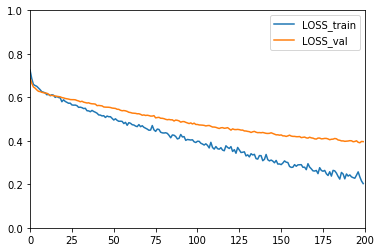

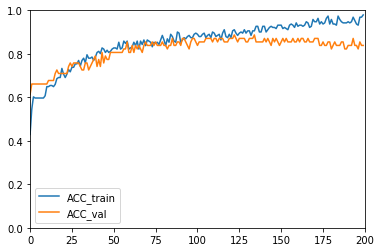

max ACC =  0.8870967741935484


In [29]:
file_path = '../Results/losses_acc_rand_lr0.00005_step200.npy'
# LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
# np.save(file_path, LOSSES)
LOSSES = np.load(file_path, allow_pickle=True)
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max().cpu().numpy())

# Visualizing the model predictions

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

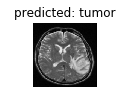

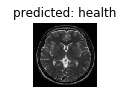

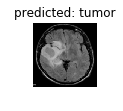

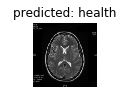

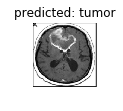

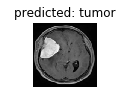

In [13]:
visualize_model(model_ft_randstart)

### Experiment 2

**Finetuning the convnet:** Instead of random initializaion, we initialize the network with a pretrained network, but they will all be retrained.

In [27]:
# static learning rate for 200 epochs

model_ft_pretrained = models.resnet18(pretrained=True)
num_ftrs = model_ft_pretrained.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_pretrained.fc = nn.Linear(num_ftrs, 2)

model_ft_pretrained = model_ft_pretrained.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft_pretrained.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.SGD(model_ft_pretrained.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=200, gamma=0.8)

In [28]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_pretrained = train_model(model_ft_pretrained, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 0.7140 Acc: 0.5759
val Loss: 0.7240 Acc: 0.5806

Epoch 1/199
----------
train Loss: 0.6954 Acc: 0.5445
val Loss: 0.6980 Acc: 0.5484

Epoch 2/199
----------
train Loss: 0.6879 Acc: 0.5969
val Loss: 0.6795 Acc: 0.5806

Epoch 3/199
----------
train Loss: 0.6532 Acc: 0.5812
val Loss: 0.6566 Acc: 0.6129

Epoch 4/199
----------
train Loss: 0.6344 Acc: 0.6335
val Loss: 0.6515 Acc: 0.6290

Epoch 5/199
----------
train Loss: 0.6323 Acc: 0.6021
val Loss: 0.6540 Acc: 0.6290

Epoch 6/199
----------
train Loss: 0.6565 Acc: 0.6335
val Loss: 0.6380 Acc: 0.6774

Epoch 7/199
----------
train Loss: 0.6127 Acc: 0.7016
val Loss: 0.6237 Acc: 0.6613

Epoch 8/199
----------
train Loss: 0.6146 Acc: 0.6806
val Loss: 0.6200 Acc: 0.6613

Epoch 9/199
----------
train Loss: 0.5916 Acc: 0.7120
val Loss: 0.6176 Acc: 0.6935

Epoch 10/199
----------
train Loss: 0.6015 Acc: 0.6545
val Loss: 0.6056 Acc: 0.6613

Epoch 11/199
----------
train Loss: 0.5978 Acc: 0.6911
val Loss: 0.6159 Acc

val Loss: 0.3831 Acc: 0.8548

Epoch 97/199
----------
train Loss: 0.3104 Acc: 0.9372
val Loss: 0.3881 Acc: 0.8548

Epoch 98/199
----------
train Loss: 0.2935 Acc: 0.9162
val Loss: 0.3751 Acc: 0.8548

Epoch 99/199
----------
train Loss: 0.2949 Acc: 0.9110
val Loss: 0.3619 Acc: 0.8548

Epoch 100/199
----------
train Loss: 0.3397 Acc: 0.8953
val Loss: 0.3608 Acc: 0.8710

Epoch 101/199
----------
train Loss: 0.3011 Acc: 0.9058
val Loss: 0.3622 Acc: 0.8710

Epoch 102/199
----------
train Loss: 0.3011 Acc: 0.9267
val Loss: 0.3514 Acc: 0.8710

Epoch 103/199
----------
train Loss: 0.2932 Acc: 0.9267
val Loss: 0.3578 Acc: 0.8548

Epoch 104/199
----------
train Loss: 0.2967 Acc: 0.9162
val Loss: 0.3594 Acc: 0.8548

Epoch 105/199
----------
train Loss: 0.2930 Acc: 0.9215
val Loss: 0.3657 Acc: 0.8548

Epoch 106/199
----------
train Loss: 0.3095 Acc: 0.9058
val Loss: 0.3808 Acc: 0.8548

Epoch 107/199
----------
train Loss: 0.3335 Acc: 0.8796
val Loss: 0.3651 Acc: 0.8548

Epoch 108/199
----------
tr

train Loss: 0.2159 Acc: 0.9476
val Loss: 0.3079 Acc: 0.9032

Epoch 193/199
----------
train Loss: 0.2322 Acc: 0.9058
val Loss: 0.2934 Acc: 0.8710

Epoch 194/199
----------
train Loss: 0.2172 Acc: 0.9372
val Loss: 0.3193 Acc: 0.8548

Epoch 195/199
----------
train Loss: 0.1969 Acc: 0.9529
val Loss: 0.3281 Acc: 0.8548

Epoch 196/199
----------
train Loss: 0.2029 Acc: 0.9372
val Loss: 0.2967 Acc: 0.8871

Epoch 197/199
----------
train Loss: 0.1893 Acc: 0.9686
val Loss: 0.3104 Acc: 0.8548

Epoch 198/199
----------
train Loss: 0.2244 Acc: 0.9424
val Loss: 0.2987 Acc: 0.8710

Epoch 199/199
----------
train Loss: 0.1832 Acc: 0.9634
val Loss: 0.3093 Acc: 0.8710

Training complete in 24m 6s
Best val Acc: 0.903226


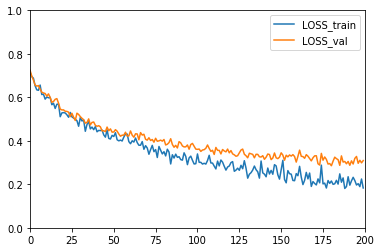

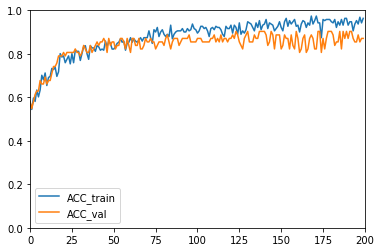

In [29]:
file_path = '../Results/losses_acc_pretrained_lr0.000005.npy'
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
np.save(file_path, LOSSES)
LOSSES = np.load(file_path, allow_pickle=True)

plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()

### Experiment 3

Freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [33]:
model_conv_pretreined = torchvision.models.resnet18(pretrained=True)
for param in model_conv_pretreined.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_pretreined.fc.in_features
model_conv_pretreined.fc = nn.Linear(num_ftrs, 2)

model_conv_pretreined = model_conv_pretreined.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv_pretreined.fc.parameters(), lr=0.00008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=200, gamma=0.8)

In [34]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_conv_pretreined = train_model(model_conv_pretreined, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 0.6327 Acc: 0.6649
val Loss: 0.6463 Acc: 0.6935

Epoch 1/199
----------
train Loss: 0.6168 Acc: 0.6440
val Loss: 0.6177 Acc: 0.7097

Epoch 2/199
----------
train Loss: 0.5905 Acc: 0.7173
val Loss: 0.5534 Acc: 0.7097

Epoch 3/199
----------
train Loss: 0.5722 Acc: 0.6963
val Loss: 0.5380 Acc: 0.7258

Epoch 4/199
----------
train Loss: 0.5277 Acc: 0.7801
val Loss: 0.5176 Acc: 0.7581

Epoch 5/199
----------
train Loss: 0.5173 Acc: 0.7801
val Loss: 0.5060 Acc: 0.7581

Epoch 6/199
----------
train Loss: 0.5007 Acc: 0.8168
val Loss: 0.4796 Acc: 0.7742

Epoch 7/199
----------
train Loss: 0.5261 Acc: 0.7906
val Loss: 0.4728 Acc: 0.7742

Epoch 8/199
----------
train Loss: 0.4858 Acc: 0.8115
val Loss: 0.4546 Acc: 0.8065

Epoch 9/199
----------
train Loss: 0.4659 Acc: 0.8010
val Loss: 0.4485 Acc: 0.7742

Epoch 10/199
----------
train Loss: 0.4537 Acc: 0.8429
val Loss: 0.4343 Acc: 0.7581

Epoch 11/199
----------
train Loss: 0.4500 Acc: 0.8063
val Loss: 0.4297 Acc

val Loss: 0.3004 Acc: 0.8710

Epoch 97/199
----------
train Loss: 0.2360 Acc: 0.9215
val Loss: 0.3002 Acc: 0.9032

Epoch 98/199
----------
train Loss: 0.2893 Acc: 0.8848
val Loss: 0.3064 Acc: 0.8871

Epoch 99/199
----------
train Loss: 0.2703 Acc: 0.9162
val Loss: 0.3353 Acc: 0.9032

Epoch 100/199
----------
train Loss: 0.2898 Acc: 0.8848
val Loss: 0.3028 Acc: 0.8871

Epoch 101/199
----------
train Loss: 0.2476 Acc: 0.9215
val Loss: 0.3299 Acc: 0.9032

Epoch 102/199
----------
train Loss: 0.2798 Acc: 0.8848
val Loss: 0.2955 Acc: 0.8710

Epoch 103/199
----------
train Loss: 0.2557 Acc: 0.9005
val Loss: 0.2967 Acc: 0.8871

Epoch 104/199
----------
train Loss: 0.2420 Acc: 0.9215
val Loss: 0.2990 Acc: 0.8871

Epoch 105/199
----------
train Loss: 0.2759 Acc: 0.8848
val Loss: 0.2913 Acc: 0.8871

Epoch 106/199
----------
train Loss: 0.2520 Acc: 0.9058
val Loss: 0.3190 Acc: 0.9032

Epoch 107/199
----------
train Loss: 0.2376 Acc: 0.9162
val Loss: 0.2973 Acc: 0.8710

Epoch 108/199
----------
tr

train Loss: 0.2085 Acc: 0.9215
val Loss: 0.2937 Acc: 0.8548

Epoch 193/199
----------
train Loss: 0.1919 Acc: 0.9424
val Loss: 0.2958 Acc: 0.8871

Epoch 194/199
----------
train Loss: 0.2116 Acc: 0.9372
val Loss: 0.2861 Acc: 0.8871

Epoch 195/199
----------
train Loss: 0.1537 Acc: 0.9686
val Loss: 0.3176 Acc: 0.8710

Epoch 196/199
----------
train Loss: 0.2156 Acc: 0.9215
val Loss: 0.2953 Acc: 0.8710

Epoch 197/199
----------
train Loss: 0.1941 Acc: 0.9319
val Loss: 0.2945 Acc: 0.9032

Epoch 198/199
----------
train Loss: 0.2331 Acc: 0.9267
val Loss: 0.2978 Acc: 0.8710

Epoch 199/199
----------
train Loss: 0.2260 Acc: 0.9162
val Loss: 0.2945 Acc: 0.8710

Training complete in 22m 19s
Best val Acc: 0.919355


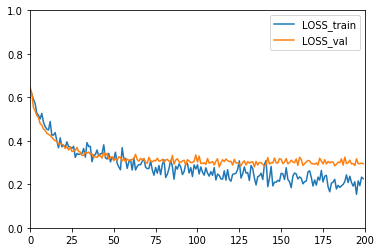

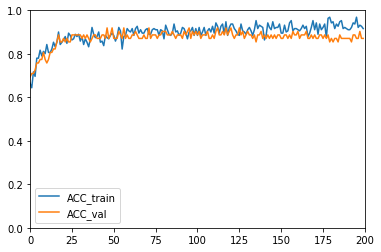

In [35]:
file_path = '../Results/losses_acc_convfix_lr0.00008_step_size_200gamma_0.8.npy'
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
np.save(file_path, LOSSES)
LOSSES = np.load(file_path, allow_pickle=True)

plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()

In [ ]:
visualize_model(model_conv_pretreined)

plt.ioff()
plt.show()

**optimizer**

![optimizer](../Images/opt.gif)

In [43]:
model_ft_randstart = models.resnet18(pretrained=False)
num_ftrs = model_ft_randstart.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_randstart.fc = nn.Linear(num_ftrs, 2)

model_ft_randstart = model_ft_randstart.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft_randstart.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.0008, momentum=0.9)
optimizer_ft_randstart = optim.RMSprop(model_ft_randstart.parameters(), lr=0.000005)
# optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.00005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)

In [44]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart,
                         exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 0.6286 Acc: 0.6283
val Loss: 0.6805 Acc: 0.7742

Epoch 1/199
----------
train Loss: 0.5272 Acc: 0.7853
val Loss: 0.6546 Acc: 0.6613

Epoch 2/199
----------
train Loss: 0.4925 Acc: 0.8220
val Loss: 0.6225 Acc: 0.6613

Epoch 3/199
----------
train Loss: 0.4446 Acc: 0.8534
val Loss: 0.5876 Acc: 0.6613

Epoch 4/199
----------
train Loss: 0.4083 Acc: 0.8743
val Loss: 0.5474 Acc: 0.6935

Epoch 5/199
----------
train Loss: 0.3859 Acc: 0.8796
val Loss: 0.5105 Acc: 0.8226

Epoch 6/199
----------
train Loss: 0.3670 Acc: 0.8639
val Loss: 0.4706 Acc: 0.8548

Epoch 7/199
----------
train Loss: 0.3290 Acc: 0.9110
val Loss: 0.4289 Acc: 0.8387

Epoch 8/199
----------
train Loss: 0.3185 Acc: 0.9005
val Loss: 0.4134 Acc: 0.8871

Epoch 9/199
----------
train Loss: 0.3030 Acc: 0.9267
val Loss: 0.4344 Acc: 0.8548

Epoch 10/199
----------
train Loss: 0.2746 Acc: 0.9267
val Loss: 0.4048 Acc: 0.8548

Epoch 11/199
----------
train Loss: 0.2503 Acc: 0.9372
val Loss: 0.3785 Acc

val Loss: 0.2189 Acc: 0.9194

Epoch 97/199
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2211 Acc: 0.9032

Epoch 98/199
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2430 Acc: 0.8871

Epoch 99/199
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.2331 Acc: 0.8871

Epoch 100/199
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2286 Acc: 0.8871

Epoch 101/199
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3384 Acc: 0.8226

Epoch 102/199
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2694 Acc: 0.8548

Epoch 103/199
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2544 Acc: 0.8710

Epoch 104/199
----------
train Loss: 0.0111 Acc: 1.0000
val Loss: 0.2024 Acc: 0.9194

Epoch 105/199
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.2457 Acc: 0.8871

Epoch 106/199
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2485 Acc: 0.8710

Epoch 107/199
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2055 Acc: 0.9032

Epoch 108/199
----------
tr

train Loss: 0.0002 Acc: 1.0000
val Loss: 0.2423 Acc: 0.9032

Epoch 193/199
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.2193 Acc: 0.9194

Epoch 194/199
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.2313 Acc: 0.9032

Epoch 195/199
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2523 Acc: 0.8871

Epoch 196/199
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2203 Acc: 0.9032

Epoch 197/199
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.2250 Acc: 0.9032

Epoch 198/199
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2240 Acc: 0.9032

Epoch 199/199
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.2058 Acc: 0.9194

Training complete in 26m 6s
Best val Acc: 0.967742


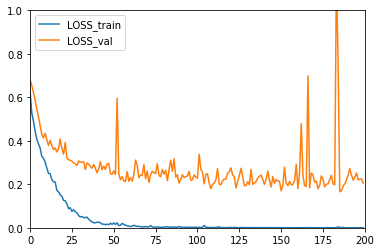

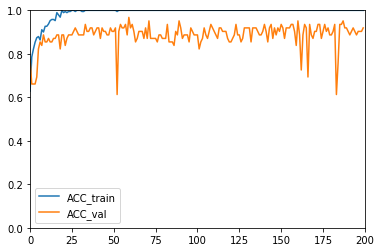

In [51]:
file_path = '../Results/losses_acc_pretrained_RMSprop_lr0.000005.npy'
# LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
# np.save(file_path, LOSSES)
LOSSES = np.load(file_path, allow_pickle=True)

plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()

# Activity

Try to get a better accuracy on the validation using the techniques you have learned. You can also try to tune the hyperparameters.

* Data augmentation (Shear, rotation, etc.)
* optimizers
* Learning rate
* number of epochs
* momentum
* ...